In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'credit-risk-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F688532%2F1207035%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240508%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240508T164506Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D9c24449eb36c50c88730496ccefd2929d40a1419f03ad4386081ea4e36de7fa9ebe97924aa4df3eeda4d25e21b9d0dfd87150125fa4665eace67dabccbdd90f3bab5a7b689aa125aa8c451a34ebb5c1eb4a36e3e4dc9d3c6fcbdb4517f3952c79223aaa7eaaa7398006a38d7d6875c0ad6a59e0ffe9fc99b20e8653fc9ffbc30a1c2988a9b40fec041b94be06e2ef7f4d5fd399c683eb2b483ebc9c67a938d116182e8da00695be646cdbc4bbdc672f06a4385a7f80d66a2ba8caa26766cfce98ac12e29733f8279a0699fbfb2441ac02c2ce9225ad956d10c936d436ff420b59c3388c613335068373c5351f810dc8bdf518f4ef5b56c65b95576a60ba5b004'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/credit-risk-dataset/credit_risk_dataset.csv


Developed a credit scoring model to predict credit scores of loan applicants and support data-driven loan approval decisions using Python.

•	Built woe logistic regression model with monotonic bad rate trend (ensuring variables reflect actual bad rate patterns)

•	Analyzed the impact of different cutoff scores on acceptance rates, bad rates, and profitability to support informed loan approval decisions. Proposed optimal score thresholds for two strategies: 1) Maximizing profit while maintaining a low-risk portfolio. 2) Aggressive market expansion with higher risk tolerance. Provided strategic recommendations for lenders based on their risk appetite and business objectives, enabling informed loan approval processes.

* tools: Python, Pandas, Scikit-learn, OptBinning, Matplotlib


In [ ]:
df = pd.read_csv('/kaggle/input/credit-risk-dataset/credit_risk_dataset.csv')
df.head(5)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [ ]:
print(f'This dataset contains of {df.shape[0]} rows and {df.shape} columns')

This dataset contains of 32581 rows and (32581, 12) columns


In [ ]:
# show info

list_item = []
for col in df.columns:
    list_item.append([col, df[col].dtype, df[col].isna().sum(), 100*df[col].isna().sum()/len(df[col]), df[col].nunique(), df[col].unique()[:4]])
desc_df = pd.DataFrame(data=list_item, columns='feature data_type null_num null_pct unique_num unique_sample'.split())
desc_df

,feature,data_type,null_num,null_pct,unique_num,unique_sample
0,person_age,int64,0,0.000000,58,"[22, 21, 25, 23]"
1,person_income,int64,0,0.000000,4295,"[59000, 9600, 65500, 54400]"
2,person_home_ownership,object,0,0.000000,4,"[RENT, OWN, MORTGAGE, OTHER]"
3,person_emp_length,float64,895,2.747000,36,"[123.0, 5.0, 1.0, 4.0]"
4,loan_intent,object,0,0.000000,6,"[PERSONAL, EDUCATION, MEDICAL, VENTURE]"
5,loan_grade,object,0,0.000000,7,"[D, B, C, A]"
6,loan_amnt,int64,0,0.000000,753,"[35000, 1000, 5500, 2500]"
7,loan_int_rate,float64,3116,9.563856,348,"[16.02, 11.14, 12.87, 15.23]"
8,loan_status,int64,0,0.000000,2,"[1, 0]"
9,loan_percent_income,float64,0,0.000000,77,"[0.59, 0.1, 0.57, 0.53]"


In [ ]:
dftrain = df

In [ ]:
!pip -q install optbinning

In [ ]:
dftrain = dftrain.dropna(axis=1, how='all')
dftrain['loan_int_rate']=dftrain['loan_int_rate']/100

In [ ]:
y = dftrain['loan_status']

# Independent variables
X = dftrain.drop(['loan_status','loan_amnt','loan_int_rate','loan_grade'], axis=1)

In [ ]:
num_defaulted = (dftrain['loan_status'] == 1).sum()
num_non_defaulted = (dftrain['loan_status'] == 0).sum()

# Calculate the total number of loans
total_loans = len(dftrain)

# Calculate the percentage of defaulted and non-defaulted loans
percent_defaulted = (num_defaulted / total_loans) * 100
percent_non_defaulted = (num_non_defaulted / total_loans) * 100

# Create a DataFrame to display the results
loan_status_summary = pd.DataFrame({
    'Loan Status': ['Defaulted', 'Non-Defaulted'],
    'Count': [num_defaulted, num_non_defaulted],
    'Percentage': [percent_defaulted, percent_non_defaulted]
})

loan_status_summary

,Loan Status,Count,Percentage
0,Defaulted,7108,21.816396
1,Non-Defaulted,25473,78.183604


Drop columns that are not be available for new loan applications 'loan_amnt','loan_int_rate','loan_grade'


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from optbinning import BinningProcess
from optbinning import Scorecard
from optbinning import OptimalBinning


(CVXPY) May 08 02:31:52 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Version of ortools (9.4.1874) is too old. Expected >= 9.5.0.')
(CVXPY) May 08 02:31:52 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Version of ortools (9.4.1874) is too old. Expected >= 9.5.0.')


methodology : model

**use OptBinning library in python to do all this**
* bin each independent variable
* calculate each bin’s information value (IV)
* calculate the log of (% of non-events / % of events) as the woe value
* replace each observation of the independent variable with the woe value
* perform WOE logistic regression on the dependent variable against the new woe dataset that has a monotonic trend in woe, and select variables based on IV
* evaluate model and create credit score




In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# Define the selection criteria for the binning process
selection_criteria = {
    "iv": {"min": 0.05}

}

# Define the special codes for missing values
special_codes = {
    -9: "missing",
    -8: "unknown",
    -7: "other"
}

# Create a binning process object
binning_process = BinningProcess(
    variable_names=X.columns.tolist(),
    special_codes=special_codes,
    selection_criteria=selection_criteria,

)

# Create a logistic regression object
estimator = LogisticRegression()

# Create a scorecard object
scorecard = Scorecard(

    binning_process=binning_process,
    estimator=estimator,
    scaling_method="pdo_odds",
    scaling_method_params={"pdo": 20, "odds": 50, "scorecard_points":600}
)

# Fit the scorecard
scorecard.fit(X_train, y_train)

# Print the scorecard table
scorecard.table(style="summary")

,Variable,Bin,Points
0,person_income,"(-inf, 23002.00)",56.146041
1,person_income,"[23002.00, 34986.00)",72.567692
2,person_income,"[34986.00, 39937.50)",83.398414
3,person_income,"[39937.50, 49986.00)",87.701697
4,person_income,"[49986.00, 59846.50)",88.337335
...,...,...,...
1,cb_person_default_on_file,[Y],61.753242
2,cb_person_default_on_file,-9,87.477157
3,cb_person_default_on_file,-8,87.477157
4,cb_person_default_on_file,-7,87.477157


In [ ]:
scorecard.table(style="summary").head(9)

,Variable,Bin,Points
0,person_income,"(-inf, 23002.00)",56.146041
1,person_income,"[23002.00, 34986.00)",72.567692
2,person_income,"[34986.00, 39937.50)",83.398414
3,person_income,"[39937.50, 49986.00)",87.701697
4,person_income,"[49986.00, 59846.50)",88.337335
5,person_income,"[59846.50, 69371.50)",94.924797
6,person_income,"[69371.50, 79942.50)",95.269075
7,person_income,"[79942.50, 108810.00)",105.994219
8,person_income,"[108810.00, inf)",107.435382


In [ ]:

ww = scorecard.table(style="detailed")
ww

,Variable,Bin id,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Coefficient,Points
0,person_income,0,"(-inf, 23002.00)",1178,0.051653,459,719,0.610357,-1.732796,0.207364,0.023098,-0.626649,56.146041
1,person_income,1,"[23002.00, 34986.00)",3154,0.138297,1933,1221,0.387127,-0.824581,0.114316,0.013898,-0.626649,72.567692
2,person_income,2,"[34986.00, 39937.50)",1576,0.069105,1170,406,0.257614,-0.225579,0.003739,0.000466,-0.626649,83.398414
3,person_income,3,"[39937.50, 49986.00)",3385,0.148426,2658,727,0.214771,0.012418,0.000023,0.000003,-0.626649,87.701697
4,person_income,4,"[49986.00, 59846.50)",3078,0.134964,2435,643,0.208902,0.047573,0.000301,0.000038,-0.626649,88.337335
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,cb_person_default_on_file,1,[Y],4007,0.175699,2514,1493,0.372598,-0.762897,0.122902,0.015001,-1.168602,61.753242
2,cb_person_default_on_file,2,-9,0,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,-1.168602,87.477157
3,cb_person_default_on_file,3,-8,0,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,-1.168602,87.477157
4,cb_person_default_on_file,4,-7,0,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,-1.168602,87.477157


In [ ]:
def check_monotonic_trends(df):
    variables = df['Variable'].unique()
    non_monotonic_vars = []

    for var in variables:
        var_data = df[df['Variable'] == var]

        # Check Event Rate monotonicity
        event_rate_sorted = var_data['Event rate'].sort_values().reset_index(drop=True)
        event_rate_diff = event_rate_sorted.diff().dropna()
        if (event_rate_diff * event_rate_diff.shift(-1) < 0).any():
            non_monotonic_vars.append((var, 'Event Rate'))

        # Check WOE monotonicity
        woe_sorted = var_data['WoE'].sort_values().reset_index(drop=True)
        woe_diff = woe_sorted.diff().dropna()
        if (woe_diff * woe_diff.shift(-1) < 0).any():
            non_monotonic_vars.append((var, 'WoE'))

    if non_monotonic_vars:
        print("The following variables have non-monotonic trends:")
        for var, column in non_monotonic_vars:
            print(f"{var} - {column}")
    else:
        print("All variables have monotonic trends in Event Rate and WOE.")

# Assuming your data is in a DataFrame called 'scorecard_table'
check_monotonic_trends(ww)

All variables have monotonic trends in Event Rate and WOE.


In [ ]:
table_df = pd.DataFrame(ww)

# Extract the variable names and coefficients
variables = table_df['Variable'].values
coefficients = table_df['Coefficient'].values

var_coef_dict = {}

for var, coef in zip(variables, coefficients):
    var_coef_dict[var] = coef

for var, coef in var_coef_dict.items():
    print(f"Variable: {var}, Coefficient: {coef:.4f}")


Variable: person_income, Coefficient: -0.6266
Variable: person_home_ownership, Coefficient: -0.8845
Variable: person_emp_length, Coefficient: -0.2723
Variable: loan_intent, Coefficient: -1.2654
Variable: loan_percent_income, Coefficient: -0.9827
Variable: cb_person_default_on_file, Coefficient: -1.1686


In [ ]:
y_pred_test = scorecard.predict_proba(X_test)[:, 1]
scores = scorecard.score(X_train)

In [ ]:
from optbinning.scorecard import  plot_cap, plot_ks, plot_auc_roc

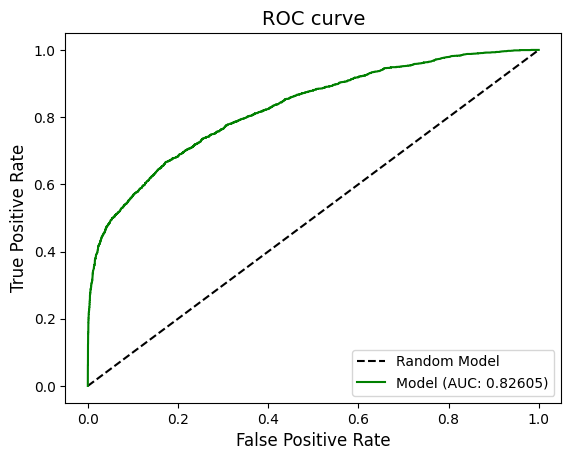

In [ ]:
plot_auc_roc(y_test, y_pred_test)

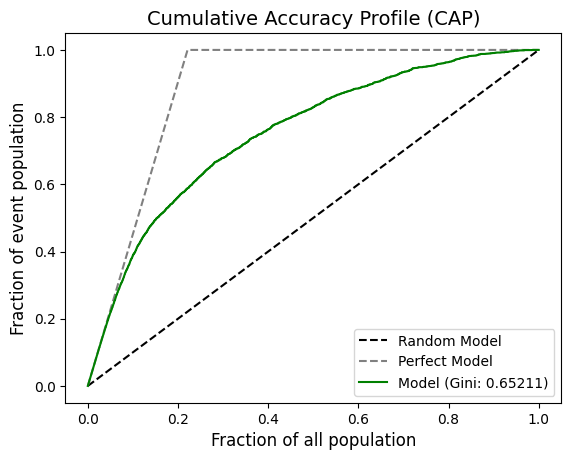

In [ ]:
plot_cap(y_test, y_pred_test)

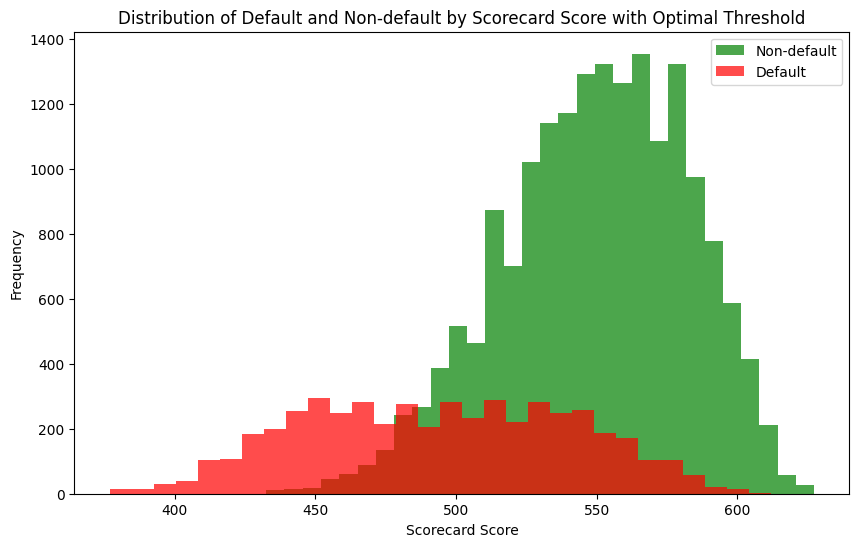

In [ ]:

# Get the default and non-default scores
default_scores = scores[y_train == 1]
non_default_scores = scores[y_train == 0]


# Now you can plot the histograms with the optimal threshold
plt.figure(figsize=(10, 6))
plt.hist(non_default_scores, bins=30, alpha=0.7, label='Non-default', color='green')
plt.hist(default_scores, bins=30, alpha=0.7, label='Default', color='red')
plt.xlabel('Scorecard Score')
plt.ylabel('Frequency')
plt.title('Distribution of Default and Non-default by Scorecard Score with Optimal Threshold')
plt.legend(loc='best')
plt.show()

The peak of the non-default distribution is at higher scores, around 550, indicating that most non-default events are concentrated in the higher score ranges. Conversely, the peak of the default distribution is at lower scores, around 450, suggesting that most default events are concentrated in the lower score ranges.

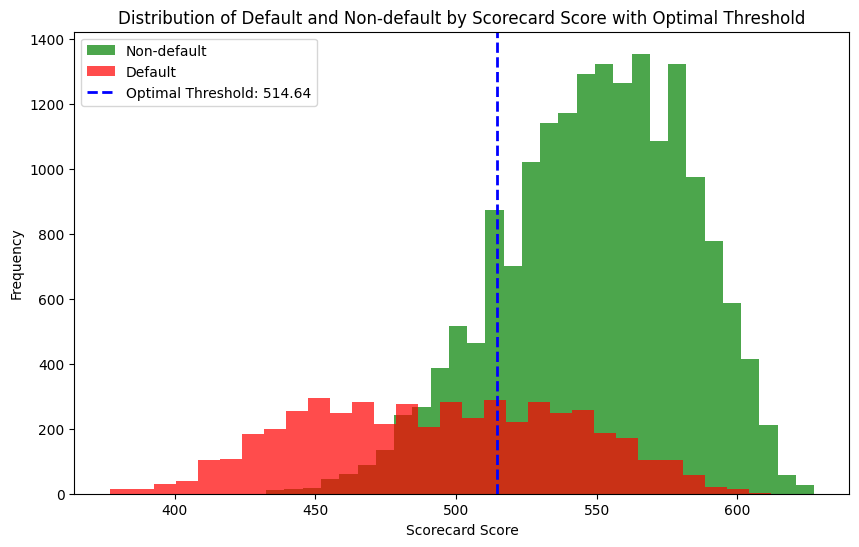

In [ ]:

# Get the default and non-default scores
default_scores = scores[y_train == 1]
non_default_scores = scores[y_train == 0]

# Find the score that maximizes the difference between the two distributions
diff = np.abs(np.cumsum(np.histogram(default_scores, bins=100, range=(scores.min(), scores.max()))[0]) / len(default_scores) -
              np.cumsum(np.histogram(non_default_scores, bins=100, range=(scores.min(), scores.max()))[0]) / len(non_default_scores))
optimal_threshold = np.argmax(diff) / 100 * (scores.max() - scores.min()) + scores.min()

# Now you can plot the histograms with the optimal threshold
plt.figure(figsize=(10, 6))
plt.hist(non_default_scores, bins=30, alpha=0.7, label='Non-default', color='green')
plt.hist(default_scores, bins=30, alpha=0.7, label='Default', color='red')
plt.axvline(optimal_threshold, color='blue', linestyle='--', linewidth=2, label=f'Optimal Threshold: {optimal_threshold:.2f}')
plt.xlabel('Scorecard Score')
plt.ylabel('Frequency')
plt.title('Distribution of Default and Non-default by Scorecard Score with Optimal Threshold')
plt.legend(loc='best')
plt.show()

First, the code separates the scores into two arrays: default_scores (containing scores of individuals who defaulted) and non_default_scores (containing scores of individuals who did not default).
The next step is to calculate the cumulative distribution functions (CDFs) of the default and non-default scores. This is done using the np.histogram function, which computes the histogram of the scores, and np.cumsum, which calculates the cumulative sum of the histogram counts.

the np.histogram function approximates these CDFs by binning the scores into 100 equal-width bins between the minimum and maximum scores.
The code then calculates the absolute difference between the CDFs of the default and non-default scores for each bin: $|F_D(s) - F_{\bar{D}}(s)|$.
The optimal threshold score is chosen as the score value $s^$ that maximizes this difference:
$$s^. = \arg\max_s |F_D(s) - F_{\bar{D}}(s)|$$
This is the score value where the two distributions are most separated, making it the best threshold for classification.

$F_D(s)$: The CDF of the default scores

$F_{\bar{D}}(s)$: The CDF of the non-default scores

in english:
* Separate scores into default and non-default groups.
* Approximate the CDFs of both groups using histograms and cumulative sums.
* Calculate the absolute difference between the two CDFs at each score bin.
* Choose the score value that maximizes this difference as the optimal threshold for classification.

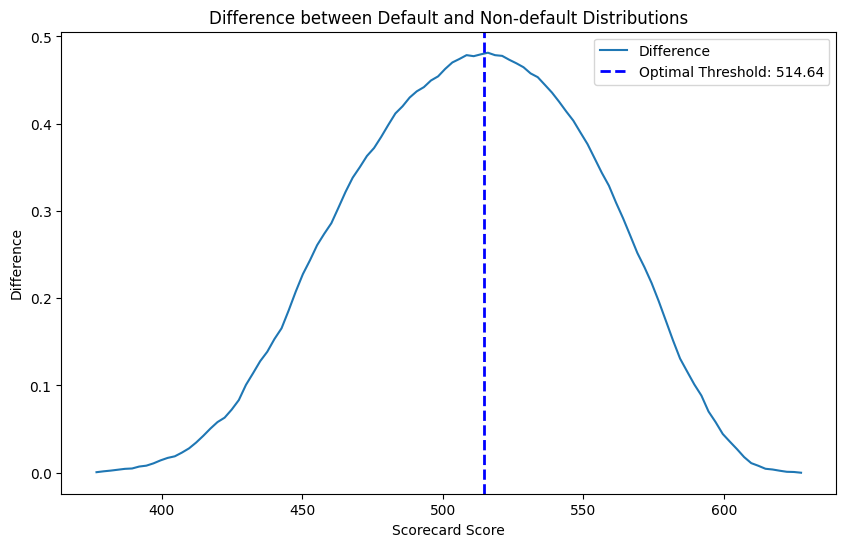

In [ ]:
# Calculate the cumulative distribution functions
cdf_default = np.cumsum(np.histogram(default_scores, bins=100, range=(scores.min(), scores.max()))[0]) / len(default_scores)
cdf_non_default = np.cumsum(np.histogram(non_default_scores, bins=100, range=(scores.min(), scores.max()))[0]) / len(non_default_scores)

# Calculate the difference
diff = np.abs(cdf_default - cdf_non_default)

# Plot the difference
plt.figure(figsize=(10, 6))
plt.plot(np.linspace(scores.min(), scores.max(), 100), diff, label='Difference')
plt.axvline(optimal_threshold, color='blue', linestyle='--', linewidth=2, label=f'Optimal Threshold: {optimal_threshold:.2f}')

plt.xlabel('Scorecard Score')
plt.ylabel('Difference')
plt.title('Difference between Default and Non-default Distributions')
plt.legend(loc='best')
plt.show()

the optimal threshold is the score value where most of the defaulters have scores below it, and most of the non-defaulters have scores above it. This means that if we use this threshold to make decisions (e.g., approve or reject loan applications), we can correctly classify most of the defaulters and non-defaulters based on their credit scores.

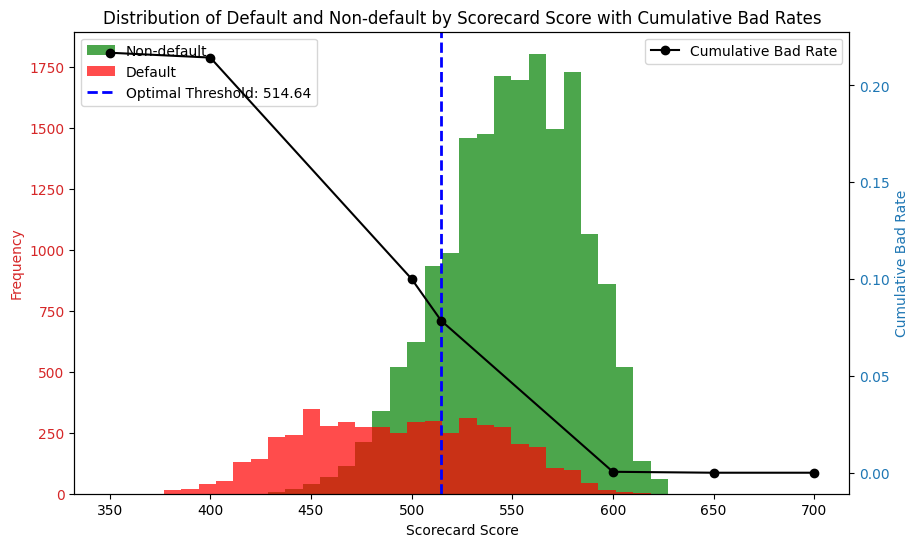

In [ ]:

total_population = len(default_scores) + len(non_default_scores)
# Define thresholds and calculate the cumulative bad rate for each threshold
thresholds = [350,400, 500,514.68, 600,650, 700]
cumulative_bad_rates = []
bins = np.linspace(scores.min(), scores.max(), 30)
bin_centers = 0.5 * (bins[1:] + bins[:-1])
default_counts, _ = np.histogram(default_scores, bins=bins)
total_population = len(default_scores) + len(non_default_scores)
bad_rate = default_counts / total_population
for threshold in thresholds:
    above_threshold = default_scores >= threshold
    cumulative_bad_rate = np.sum(above_threshold) / total_population
    cumulative_bad_rates.append(cumulative_bad_rate)

# Now you can plot the histograms with the optimal threshold
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.hist(non_default_scores, bins=bins, alpha=0.7, label='Non-default', color='green')
ax1.hist(default_scores, bins=bins, alpha=0.7, label='Default', color='red')
ax1.axvline(optimal_threshold, color='blue', linestyle='--', linewidth=2, label=f'Optimal Threshold: {optimal_threshold:.2f}')
ax1.set_xlabel('Scorecard Score')
ax1.set_ylabel('Frequency', color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')
ax1.legend(loc='upper left')

# Plot the cumulative bad rates
ax2 = ax1.twinx()
ax2.plot(thresholds, cumulative_bad_rates, 'o-', color='black', label='Cumulative Bad Rate')
ax2.set_ylabel('Cumulative Bad Rate', color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')
ax2.legend(loc='upper right')

plt.title('Distribution of Default and Non-default by Scorecard Score with Cumulative Bad Rates')
plt.show()


In [ ]:


# Assuming 'scores' and 'y_train' are already defined



# Define thresholds and calculate the cumulative bad rate and acceptance rate for each threshold
thresholds = [200, 300,480, 400, 500,514.64,550, 600,650, 700, 800, 900]
cumulative_bad_rates = []
acceptance_rates = []

for threshold in thresholds:
    accepted = scores >= threshold
    acceptance_rate = np.sum(accepted) / total_population
    acceptance_rates.append(acceptance_rate)
    above_threshold = default_scores >= threshold
    cumulative_bad_rate = np.sum(above_threshold) / total_population
    cumulative_good_rate = np.sum(above_threshold==0)/ total_population
    cumulative_bad_rates.append(cumulative_bad_rate)

# Create a DataFrame from the thresholds, cumulative bad rates, and acceptance rates
data = {
    'Score Threshold': thresholds,
    'Cumulative Bad Rate': cumulative_bad_rates,
    'Acceptance Rate': acceptance_rates

}
df = pd.DataFrame(data)

# Convert the rates to percentage format for better readability
df['Cumulative Bad Rate'] = (df['Cumulative Bad Rate'] * 100).apply(lambda x: f'{x:.2f}%')
df['Acceptance Rate'] = (df['Acceptance Rate'] * 100).apply(lambda x: f'{x:.2f}%')

# Display the DataFrame
df

,Score Threshold,Cumulative Bad Rate,Acceptance Rate
0,200.00,21.69%,100.00%
1,300.00,21.69%,100.00%
2,480.00,12.78%,89.19%
3,400.00,21.44%,99.75%
4,500.00,10.01%,81.79%
5,514.64,7.86%,73.80%
6,550.00,2.85%,43.43%
7,600.00,0.05%,3.63%
8,650.00,0.00%,0.00%
9,700.00,0.00%,0.00%


In [ ]:
# Assuming 'scores' and 'y_train' are already defined

# Define thresholds and calculate the cumulative bad rate and acceptance rate for each threshold
thresholds = [300, 400, 500,514,550, 600]
cumulative_bad_rates = []
acceptance_rates = []
cumulative_good_rates = []
for threshold in thresholds:
    accepted = scores >= threshold
    acceptance_rate = np.sum(accepted) / total_population
    acceptance_rates.append(acceptance_rate)

    above_threshold = default_scores >= threshold
    cumulative_bad_rate = np.sum(above_threshold) / total_population
    cumulative_bad_rates.append(cumulative_bad_rate)

    # Calculate the cumulative good rate
    cumulative_good_rate = 1 - cumulative_bad_rate
    cumulative_good_rates.append(cumulative_good_rate)

# Create a DataFrame from the thresholds, cumulative bad rates, acceptance rates, and cumulative good rates
data = {
    'Score Threshold': thresholds,
    'Cumulative Bad Rate': cumulative_bad_rates,
    'Cumulative Good Rate': cumulative_good_rates,
    'Acceptance Rate': acceptance_rates
}
df = pd.DataFrame(data)

# Convert the rates to percentage format for better readability
df['Cumulative Bad Rate'] = (df['Cumulative Bad Rate'] * 100).apply(lambda x: f'{x:.2f}%')
df['Acceptance Rate'] = (df['Acceptance Rate'] * 100).apply(lambda x: f'{x:.2f}%')
df['Cumulative Good Rate'] = (df['Cumulative Good Rate'] * 100).apply(lambda x: f'{x:.2f}%')

# Display the DataFrame
df

,Score Threshold,Cumulative Bad Rate,Cumulative Good Rate,Acceptance Rate
0,300,21.69%,78.31%,100.00%
1,400,21.44%,78.56%,99.75%
2,500,10.01%,89.99%,81.79%
3,514,7.98%,92.02%,74.34%
4,550,2.85%,97.15%,43.43%
5,600,0.05%,99.95%,3.63%


* The Cumulative Bad Rate is calculated as the number of defaulted loans with a score equal to or above the given threshold, divided by the total number of loans (both defaulted and non-defaulted) in the population. It represents the expected default rate if you were to approve all loan applications with scores at or above that threshold.
* So, suppose you were to set a threshold of, say, 514 (optimal threshold before). In that case, This score can be considered the optimal cutoff score because it strikes the best balance between accepting a reasonable number of loans (73.74%) and keeping the bad rate relatively low (7.86%).


In [ ]:

# Define thresholds and calculate the cumulative bad rate and acceptance rate for each threshold
thresholds = [300, 400, 500,514,550, 600]
cumulative_bad_rates = []
acceptance_rates = []
non_default_below_threshold_rates = []

for threshold in thresholds:
    accepted = scores >= threshold
    acceptance_rate = np.sum(accepted) / total_population
    acceptance_rates.append(acceptance_rate)

    above_threshold = default_scores >= threshold
    cumulative_bad_rate = np.sum(above_threshold) / total_population
    cumulative_bad_rates.append(cumulative_bad_rate)

    # Calculate the percentage of non-defaults below the threshold
    non_default_scores = scores[y_train == 0]
    below_threshold = non_default_scores < threshold
    non_default_below_threshold_rate = np.sum(below_threshold) / len(non_default_scores)
    non_default_below_threshold_rates.append(non_default_below_threshold_rate)

# Create a DataFrame from the thresholds, cumulative bad rates, acceptance rates, and non-default below threshold rates
data = {
    'Score Threshold': thresholds,
    'Cumulative Bad Rate': cumulative_bad_rates,
    'Non-Default Below Threshold Rate': non_default_below_threshold_rates,
    'Acceptance Rate': acceptance_rates
}
df = pd.DataFrame(data)

# Convert the rates to percentage format for better readability
df['Cumulative Bad Rate'] = (df['Cumulative Bad Rate'] * 100).apply(lambda x: f'{x:.2f}%')
df['Acceptance Rate'] = (df['Acceptance Rate'] * 100).apply(lambda x: f'{x:.2f}%')
df['Non-Default Below Threshold Rate'] = (df['Non-Default Below Threshold Rate'] * 100).apply(lambda x: f'{x:.2f}%')

# Display the DataFrame
df

,Score Threshold,Cumulative Bad Rate,Non-Default Below Threshold Rate,Acceptance Rate
0,300,21.69%,0.00%,100.00%
1,400,21.44%,0.00%,99.75%
2,500,10.01%,8.35%,81.79%
3,514,7.98%,15.26%,74.34%
4,550,2.85%,48.18%,43.43%
5,600,0.05%,95.43%,3.63%


In [ ]:
import pandas as pd

# Assume you have a DataFrame named 'dftrain' with the necessary columns
dftrain = dftrain.copy()  # Create a copy to avoid modifying the original data

# Calculate the total amount to be paid back
dftrain['total_amount'] = dftrain['loan_amnt'] * (1 + dftrain['loan_int_rate'])

# Calculate the profit/loss
dftrain['profit_loss'] = dftrain.apply(lambda row: -row['loan_amnt'] if row['loan_status'] == 1 else row['total_amount'] - row['loan_amnt'], axis=1)

# Calculate the total profit/loss
total_profit_loss = dftrain['profit_loss'].sum()

print(f"Total Profit/Loss: ${total_profit_loss:.2f}")

Total Profit/Loss: $-54463425.11


To calculate the profit or loss for each loan, we consider two scenarios:
* profit_loss=loan_amnt* (1+loan_int_rate)-loan_amnt   
* **(if loan does not default)**
* profit_loss=-loan_amnt                                    
* **(if loan defaults)**


the profit/loss for each loan is calculated using the following formula:

$$
\text{profit_loss} = \begin{cases}
-\text{loan_amnt}, & \text{if loan_status = 1 (default)} \\
\text{total_amount} - \text{loan_amnt}, & \text{otherwise}
\end{cases}
$$

After calculating the profit_loss for each loan, the total profit/loss is obtained by summing up these individual values:
$$
\text{total_profit_loss} = \sum_{i=1}^{n} \text{profit_loss}_i
$$

In [ ]:
loanpl = dftrain[['loan_amnt','loan_int_rate','profit_loss','loan_status']]
loanpl

,loan_amnt,loan_int_rate,profit_loss,loan_status
0,35000,0.1602,-35000.0000,1
1,1000,0.1114,111.4000,0
2,5500,0.1287,-5500.0000,1
3,35000,0.1523,-35000.0000,1
4,35000,0.1427,-35000.0000,1
...,...,...,...,...
32576,5800,0.1316,763.2800,0
32577,17625,0.0749,1320.1125,0
32578,35000,0.1099,-35000.0000,1
32579,15000,0.1148,1722.0000,0


In [ ]:

# Assuming dftrain is the original DataFrame containing all the necessary columns

# Calculate the total amount (loan amount + interest)
dftrain['total_amount'] = dftrain['loan_amnt'] * (1 + dftrain['loan_int_rate'])

# Split the data into features (X_train) and target (y_train)
X_train = dftrain.drop(['loan_amnt', 'loan_int_rate', 'loan_status'], axis=1)
y_train = dftrain['loan_status']

# Calculate the scores for the training set
train_scores = scorecard.score(X_train)


# Define thresholds and calculate the cumulative bad rate, acceptance rate, and profit for each threshold
thresholds = [350, 400, 450, 500, 514.64,537,538, 550, 600,650]
cumulative_bad_rates = []
acceptance_rates = []
profits = []

for threshold in thresholds:
    accepted = train_scores >= threshold
    accepted_loans = dftrain[accepted]
    acceptance_rate = len(accepted_loans) / len(y_train)
    acceptance_rates.append(acceptance_rate)

    above_threshold = train_scores[y_train == 1] >= threshold
    cumulative_bad_rate = np.sum(above_threshold) / len(dftrain)
    cumulative_bad_rates.append(cumulative_bad_rate)

    # Calculate the profit/loss
    accepted_loans['profit_loss'] = accepted_loans.apply(lambda row: -row['loan_amnt'] if row['loan_status'] == 1 else row['total_amount'] - row['loan_amnt'], axis=1)
    profit = accepted_loans['profit_loss'].sum()
    profits.append(profit)

# Create a DataFrame from the thresholds, cumulative bad rates, acceptance rates, and profits
data = {
    'Score Threshold': thresholds,
    'Cumulative Bad Rate': cumulative_bad_rates,
    'Acceptance Rate': acceptance_rates,
    'Profit': profits
}
df = pd.DataFrame(data)

# Convert the rates to percentage format for better readability
df['Cumulative Bad Rate'] = (df['Cumulative Bad Rate'] * 100).apply(lambda x: f'{x:.2f}%')
df['Acceptance Rate'] = (df['Acceptance Rate'] * 100).apply(lambda x: f'{x:.2f}%')

pd.options.display.float_format = '{:.2f}'.format

# Display the DataFrame
df

/tmp/ipykernel_33/3606876427.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accepted_loans['profit_loss'] = accepted_loans.apply(lambda row: -row['loan_amnt'] if row['loan_status'] == 1 else row['total_amount'] - row['loan_amnt'], axis=1)


,Score Threshold,Cumulative Bad Rate,Acceptance Rate,Profit
0,350.00,21.82%,100.00%,-54463425.11
1,400.00,21.57%,99.76%,-53688950.12
2,450.00,17.19%,95.22%,-35332310.50
3,500.00,10.09%,81.83%,-9381296.51
4,514.64,7.86%,73.74%,-5082928.43
5,537.00,4.62%,56.13%,-125748.83
6,538.00,4.48%,55.31%,14842.43
7,550.00,2.85%,43.50%,2292758.42
8,600.00,0.04%,3.59%,767715.67
9,650.00,0.00%,0.00%,0.00


In [ ]:
#df.to_csv('filename.csv', index=False)

At a score threshold of 538.0, the data shows a least positive profit of $14,842.43 and the acceptance rate is 55.31%. This threshold represents the highest score value, relatively low acceptance  

In [ ]:
# Define the range of thresholds and calculate the cumulative bad rate, acceptance rate, and profit for each threshold
min_threshold = 510
max_threshold = 600
step_size = 1
thresholds = range(min_threshold, max_threshold + step_size, step_size)
cumulative_bad_rates = []
acceptance_rates = []
profits = []

for threshold in thresholds:
    accepted = train_scores >= threshold
    accepted_loans = dftrain[accepted]
    acceptance_rate = len(accepted_loans) / len(y_train)
    acceptance_rates.append(acceptance_rate)

    above_threshold = train_scores[y_train == 1] >= threshold
    cumulative_bad_rate = np.sum(above_threshold) / len(dftrain)
    cumulative_bad_rates.append(cumulative_bad_rate)

    # Calculate the profit/loss
    accepted_loans['profit_loss'] = accepted_loans.apply(lambda row: -row['loan_amnt'] if row['loan_status'] == 1 else row['total_amount'] - row['loan_amnt'], axis=1)
    profit = accepted_loans['profit_loss'].sum()
    profits.append(profit)

# Create a DataFrame from the thresholds, cumulative bad rates, acceptance rates, and profits
data = {
    'Score Threshold': thresholds,
    'Cumulative Bad Rate': cumulative_bad_rates,
    'Acceptance Rate': acceptance_rates,
    'Profit': profits
}
df = pd.DataFrame(data)

# Convert the rates to percentage format for better readability
df['Cumulative Bad Rate'] = (df['Cumulative Bad Rate'] * 100).apply(lambda x: f'{x:.2f}%')
df['Acceptance Rate'] = (df['Acceptance Rate'] * 100).apply(lambda x: f'{x:.2f}%')
pd.options.display.float_format = '{:.2f}'.format

# Find the score threshold with profit closest to 0
closest_profit = df['Profit'].abs().min()
closest_threshold = df[df['Profit'].abs() == closest_profit]['Score Threshold'].values[0]

print(f"The score threshold with profit closest to 0 is: {closest_threshold}")
print(f"Profit at this threshold: {closest_profit:.2f}")

/tmp/ipykernel_33/1972205852.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accepted_loans['profit_loss'] = accepted_loans.apply(lambda row: -row['loan_amnt'] if row['loan_status'] == 1 else row['total_amount'] - row['loan_amnt'], axis=1)


The score threshold with profit closest to 0 is: 538
Profit at this threshold: 14842.43


**strategy**

**Score Threshold of 538+ (customers with below this score will got reject).**
choosing a score threshold of 538.0 would be an appropriate strategy in situations where the lender prioritizes a low-risk portfolio and maintaining a positive profit, even if modest. This approach may be suitable in the following scenarios:
* Economic Downturn or Recessionary Environment  lenders may adopt a more conservative stance to mitigate potential losses
* Risk-Averse Lending Approach: Some lenders may have a lower tolerance for risk and prefer to maintain a high-quality loan portfolio

**Score Threshold of 514+**
On the other hand, choosing a score threshold of 514 would be a suitable strategy when the lender aims to capture a larger market share and is willing to accept a higher level of risk This approach may be advantageous in the following situations:
* Aggressive Market Expansion: If the lender operates in a highly competitive market and seeks to gain a significant market share, a lower score cutoff like 514.64 can help approve more loan applications.
* High Risk Tolerance: Lenders with a higher tolerance for risk may be willing to accept the potential losses associated with a lower score threshold like 514.64


thank you